## ARIMA(Autoregressive Intergrated Moving Average) 모델
    1) Stationary VS Non-Stationary time series
    - Stationary 데이터 특성
        (1) 연속되는 숫자들의 평균이 time invariant : 시간이 지나도 평균이 일정
        (2) 연속되는 숫자들의 분산이 time invariant : 시간이 지나도 분산이 일정
        (3) 연속되는 숫자들의 공분산이 time invariant : 시간이 지나도 frequency가 일정(주기가 일정)    
    
    - Stationary Test
    : ARIMA 모델은 시계열 데이터가 stationary 특성을 보일 때 효과적이므로 이를 Stationary성을 테스트해야함
    ex)Dickey-Fuller Test
    
    - Differencing
    : Stationary하지 않은 데이터를 Differencing하는 작업(Integrated)으로 Stationary하게 변형할 필요 있음.
      여기서 Differencing이 d에 해당. d를 가정하고 p,q를 구하는게 ARIMA 가정.
      seasonal 데이터의 경우 season을 기준으로 differencing한다. 
      가령 1년 주기의 seasonality라면 월간 데이터에 대해 d할 때,시간단위는 12가 됨
    
    
    2) Seasonal VS Non-Seasonal ARIMA
    - Non-Seasonal ARIMA : ARIMA(p,d,q)
    - Seasonal ARIMA : ARIMA(p,d,q)(P,D,Q)m
    3) ARIMA
    - Autoregressive : AR(p)
        t시점의 데이터와 이전 시점(t-p:lagged p)의 데이터 사이의 관계에 대한 회귀모델
    - Intergrated : I(d)
        
    - Moving Average : MA(q)
        t시점의 데이터와 이전 시점(t-q)의 moving average의 residual에 대한 회귀모델
        노이즈를 예측하는 것
    
    Identification of ARIMA
    - I(d) : stationary로 변환한 order d
    - AR(p),MA(q) : AutoCorrelation 플롯과 Partial AutoCorrelation Plot을 참고해서 p와 q를 결정.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [59]:
milk=pd.read_csv("data/monthly-milk-production-pounds.csv",index_col="Month",parse_dates=True)
milk.rename(columns = {"Monthly milk production: pounds per cow. Jan 62 ? Dec 75" : 'pounds per cow'}, inplace = True)
milk=milk[:-1]
milk.index=pd.to_datetime(milk.index)

<AxesSubplot:xlabel='Month'>

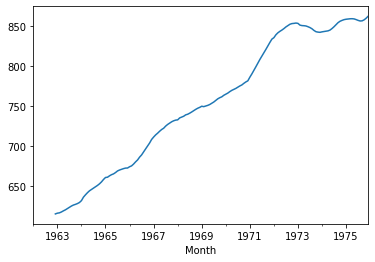

In [60]:
timeseries=milk['pounds per cow']
timeseries.rolling(12).mean().plot()

<AxesSubplot:xlabel='Month'>

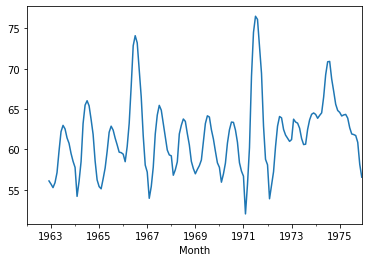

In [61]:
timeseries.rolling(12).std().plot()
# 중간 지점만 variance가 일정하게 유지되나, 그 외 구간에서 time invariant

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(milk["pounds per cow"])

<Figure size 864x504 with 0 Axes>

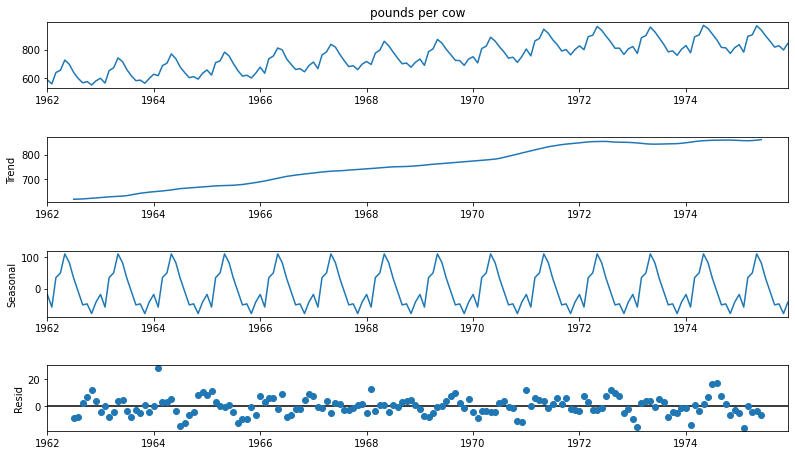

In [67]:
fig=plt.figure(figsize=(12,7))
fig=decomposition.plot()
fig.set_size_inches(12,7)
'''
아래 그래프로 보듯이 트렌드와 시즌성 확실히 갖고 있음.
이제 residual에서 모델을 구하고 여기에 시즌성과 트렌드 더해줌
'''

In [72]:
# Stationary 확인
from statsmodels.tsa.stattools import adfuller
result=adfuller(milk["pounds per cow"])
result
'''
result=
(-1.3038115874221246,
 0.627426708603034, <<< 이게 p값이고 0.05보다 작으면 stationary하다고 판단 가능
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

'''

(-1.3038115874221246,
 0.627426708603034,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [78]:
# stationary를 체크하는 과정을 함수로 만들기
def adf_check(time_series):
    result=adfuller(time_series)
    if result[1]<=0.05:
        return "Stationary, p-value : {}".format(result[1])
    else:
        return "Non-Stationary, p-value : {}".format(result[1])

adf_check(milk["pounds per cow"])

'Non-Stationary, p-value : 0.627426708603034'

In [98]:
## Deferrencing
# shift로 1개 값을 밀어서 1기 전 기간 데이터에서 빼준 것을 1st_diff로 저장
milk["1st_diff"]=milk["pounds per cow"]-milk["pounds per cow"].shift(1)
adf_check(milk["1st_diff"].dropna())
# stationary한 데이터로 변형

'Stationary, p-value : 0.03006800400178688'

<AxesSubplot:xlabel='Month'>

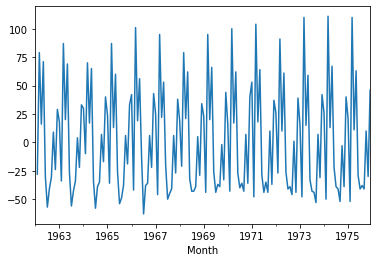

In [99]:
# 이전보다 stationary함
milk["1st_diff"].plot()

In [104]:
# shift로 2개 값을 밀어서 2기 전 기간 데이터에서 빼준 것을 2nd_diff로 저장
milk["2nd_diff"]=milk["pounds per cow"]-milk["pounds per cow"].shift(2)
adf_check(milk["2nd_diff"].dropna())
# 1기보다 좀 더 p-value 작아짐

'Stationary, p-value : 0.028964953375465844'

<AxesSubplot:xlabel='Month'>

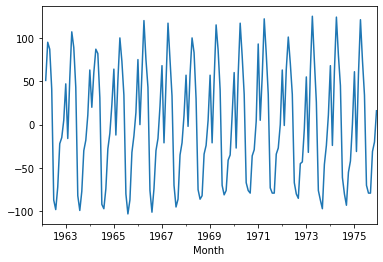

In [105]:
milk["2nd_diff"].plot()

'Non-Stationary, p-value : 0.16079880527711304'

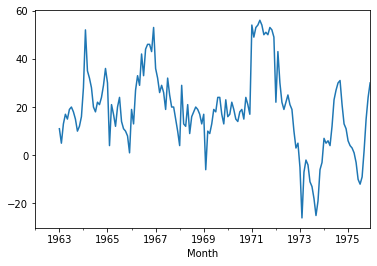

In [111]:
# differencing한 데이터에서도 seasonal이 존재하므로, seasonal에 대한 differencing해준다
milk["seasonal_diff"]=milk["pounds per cow"]-milk["pounds per cow"].shift(12)
milk["seasonal_diff"].plot()
adf_check(milk["seasonal_diff"].dropna())

'Stationary, p-value : 1.86542343187882e-05'

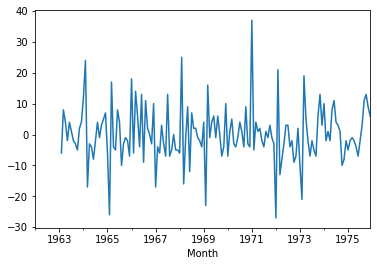

In [120]:
# 위처럼 원본에다가 differencing을 하거나 혹은 1st_diff에 seasonal differencing을 해준다
milk["seasonal_1st_diff"]=milk["1st_diff"]-milk["1st_diff"].shift(12)
milk["seasonal_1st_diff"].plot()
adf_check(milk["seasonal_1st_diff"].dropna())
# Stationary, 1.86542343187882e-05<=0.05

In [123]:
d=1
D=1

In [124]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

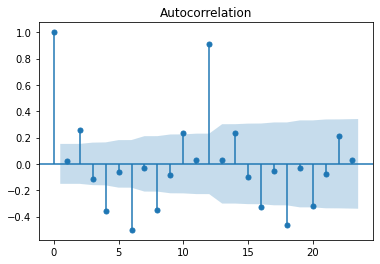

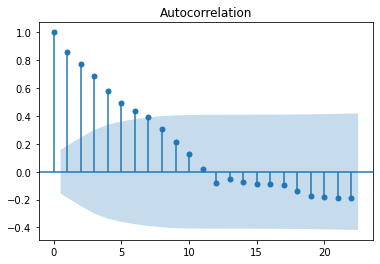

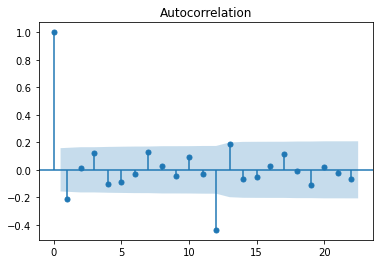

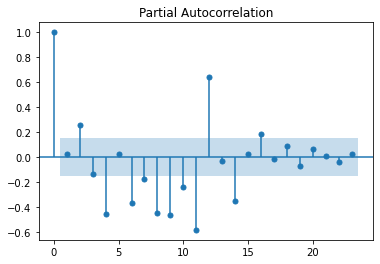

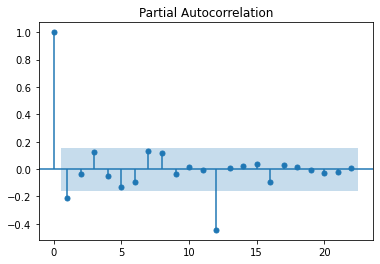

In [138]:
plot_acf(milk["1st_diff"].dropna());
plot_acf(milk["seasonal_diff"].dropna());
plot_acf(milk["seasonal_1st_diff"].dropna());
plot_pacf(milk["1st_diff"].dropna(),method="ywm");
plot_pacf(milk["seasonal_1st_diff"].dropna(),method="ywm");

In [139]:
P=1
Q=1
p=0
q=0

In [141]:
model=sm.tsa.statespace.SARIMAX(milk["pounds per cow"],
                               order=(p,d,q),
                               seasonal_order=(1,1,1,12))
result=model.fit()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [143]:
result.summary()
'''
하기 결과에서 AIC와 BIC가 모델의 성능이라고 할 수 있음.

'''

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Sun, 25 Oct 2020   AIC                           1074.131
Time:                                      00:18:07   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102     -5.762      0.000      -0.785      -0.387
sigma2        55.5118      5.356     10.365      0.000      45.015      66.009
===================================================================================
Ljung-Box (L1) (Q):                   8.13   Jarque-Bera (JB):                32.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.77
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

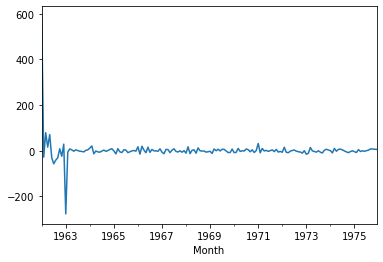

In [147]:
result.resid.plot()

<AxesSubplot:ylabel='Density'>

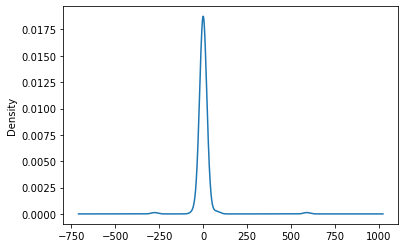

In [148]:
# 가우시안 분포로 그리기
result.resid.plot(kind="kde")
# 평균이 0에 근사하는 정규분포, bias 없음. 이 모델로 prediction

In [155]:
milk["forecast"]=result.predict(start=150,end=len(milk),dynamic=True)

<AxesSubplot:xlabel='Month'>

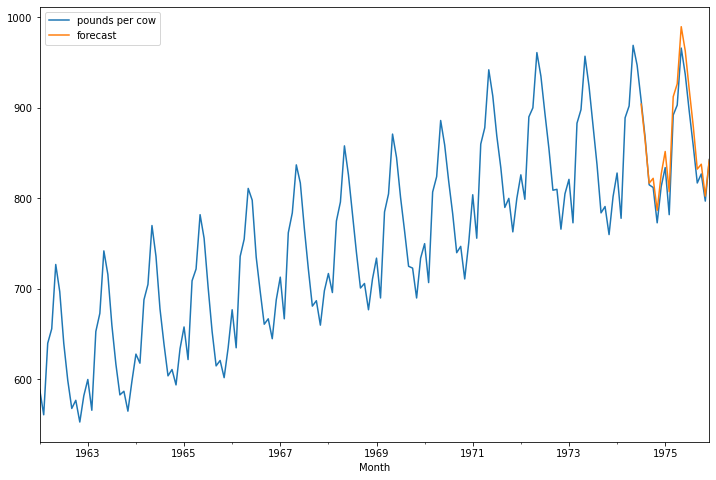

In [160]:
milk[["pounds per cow","forecast"]].plot(figsize=(12,8))